In [4]:
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [5]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [6]:
torch.__version__  

'2.3.0'

In [7]:
from torch.utils.data import Dataset,DataLoader
from captcha.image import ImageCaptcha
from random import randint,seed
from tqdm import tqdm

In [8]:
DIGIT=4
num_classes =36

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
char_list=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']



In [12]:
class CaptchaData(Dataset):
    def __init__(self,char_list,num,transform=None):
        self.char_list=char_list
        self.char2index={
            self.char_list[i]:i for i in range (len(self.char_list))
        }
        self.label_list=[]
        self.img_list=[]
        #Number of Cpatcha
        self.num=num
        self.transform = transform
        for i in tqdm(range(self.num)):
            chars=""
            for i in range(DIGIT):
                chars+= char_list[randint(0,len(self.char_list)-1)]
            img =ImageCaptcha().generate_image(chars)
            self.img_list.append(img)
            self.label_list.append(chars)
    def __getitem__(self, index):
        chars=self.label_list[index]
        image=self.img_list[index]
        if self.transform:
            image = self.transform(image)

        #One Hot
        chars_tensor=self._numerical(chars)
        label=chars_tensor.long().unsqueeze(1)
        label_onehot=torch.zeros(DIGIT,36)
        label_onehot.scatter_(1,label,1)
        label=label_onehot.view(-1)

        return image,label

    def _numerical(self,chars):
        char_tensor=torch.zeros(DIGIT)
        for i in range(len(chars)):
            char_tensor[i]=self.char2index[chars[i]]
        return char_tensor


    def __len__(self):
        return self.num
    
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [13]:
train= CaptchaData(char_list,num=10000, transform=data_transforms)
train_loader=DataLoader(train,batch_size=32,shuffle=True)
valid= CaptchaData(char_list,num=2000, transform=data_transforms)
valid_loader=DataLoader(valid,batch_size=32,shuffle=False)

100%|██████████| 2000/2000 [00:07<00:00, 279.30it/s]


tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

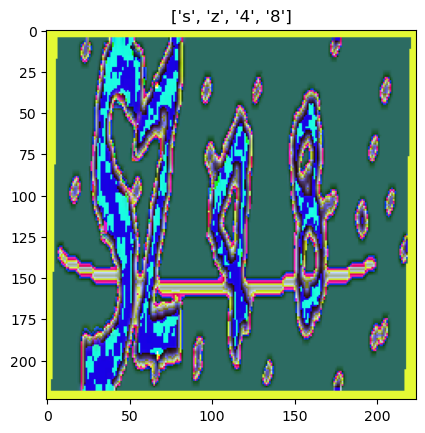

In [14]:
img,label=train[5]
print(img)
pred=torch.argmax(label.view(-1,36),dim=1)
print(pred)
plt.title([char_list[lab.int()] for lab in pred])
plt.imshow(transforms.ToPILImage()(img))
plt.show()


In [15]:
class ResNet18Captcha(nn.Module):
    def __init__(self, num_classes=36, num_digits=4):
        super(ResNet18Captcha, self).__init__()
        
        # 載入 ResNet18 模型，去掉原來的分類層
        self.resnet18 = models.resnet18(pretrained=True)
        # 替換原來的 fully connected layer，設為適應 144 類（36 x 4）
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes * num_digits)
        
    def forward(self, x):
        return self.resnet18(x)

# 建立模型
model = ResNet18Captcha(num_classes=36, num_digits=4)
print(model)

/home/how1215/anaconda3/envs/test_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/how1215/anaconda3/envs/test_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18Captcha(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [16]:
criteron=nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
epoch_lr=[
   (50,0.001)
]

In [ ]:
def train():
    model.to(device)
    acces=[]
    losses=[]
    val_acces=[]
    val_losses=[]
    for n,(num_epoch,lr) in enumerate(epoch_lr):
        for epoch in range(num_epoch):
            model.train()
            epoch_loss=0.0
            epoch_acc=0.0
            for i,(img,label) in tqdm(enumerate(train_loader)):
                output=model(img.to(device))
                label=label.to(device)

                optimizer.zero_grad()

                loss=criteron(output,label)

                loss.backward()
                optimizer.step()

                pred=torch.argmax(output.view(-1,36),dim=1)
                true_lab=torch.argmax(label.view(-1,36),dim=1)

                epoch_acc+=torch.sum(pred==true_lab).item()
                epoch_loss+=loss.item()
            if epoch % 3 == 0:
                with torch.no_grad():
                    model.eval()
                    val_loss=0.0
                    val_acc=0.0
                    for i,(img,label) in tqdm(enumerate(valid_loader)):
                        output=model(img.to(device))
                        label=label.to(device)
                        pred=torch.argmax(output.view(-1,36),dim=1)
                        true_lab=torch.argmax(label.view(-1,36),dim=1)
                        val_acc+=torch.sum(pred==true_lab).item()
                        val_loss+=loss.item()
                val_acc /= len(valid_loader.dataset)*4
                val_loss/= len(valid_loader)
            epoch_acc /= len(train_loader.dataset)*4
            epoch_loss/= len(train_loader)
            print(
                "epoch: {} , epoch loss {} , epoch accuracy {}".format(
                    epoch+sum([e[0] for e in epoch_lr[:n]]),epoch_loss,epoch_acc
                )

            )
            if epoch % 3 == 0:
                print(
                "epoch: {} , val loss {} , val accuracy {}".format(
                    epoch+sum([e[0] for e in epoch_lr[:n]]),val_loss,val_acc
                    )
                )
                for i in range(3):
                    val_acces.append(val_acc)
                    val_losses.append(val_loss)
            acces.append(epoch_acc)
            losses.append(epoch_loss)
    torch.save(model.state_dict(), "model.pth")       
    print(losses)
    print(val_losses)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Train Loss')
    plt.plot(val_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acces, label='Train Accuracy')
    plt.plot(val_acces, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

0it [00:00, ?it/s]/home/how1215/anaconda3/envs/test_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
313it [01:05,  4.74it/s]
63it [00:07,  8.99it/s]


epoch: 0 , epoch loss 0.13378324819068177 , epoch accuracy 0.02855
epoch: 0 , val loss 0.12758588790893555 , val accuracy 0.0305


313it [00:55,  5.62it/s]


epoch: 1 , epoch loss 0.12336437461284784 , epoch accuracy 0.0571


313it [00:57,  5.45it/s]


epoch: 2 , epoch loss 0.07226060549862469 , epoch accuracy 0.505025


313it [00:57,  5.48it/s]
63it [00:12,  5.10it/s]


epoch: 3 , epoch loss 0.027692880383290992 , epoch accuracy 0.89975
epoch: 3 , val loss 0.018540268763899803 , val accuracy 0.936625


313it [00:59,  5.22it/s]


epoch: 4 , epoch loss 0.012066769589202853 , epoch accuracy 0.970225


313it [00:59,  5.28it/s]


epoch: 5 , epoch loss 0.00700576568897159 , epoch accuracy 0.9828


313it [00:58,  5.37it/s]
63it [00:07,  8.73it/s]


epoch: 6 , epoch loss 0.004797720787719416 , epoch accuracy 0.98865
epoch: 6 , val loss 0.004907332360744476 , val accuracy 0.974625


313it [00:58,  5.35it/s]


epoch: 7 , epoch loss 0.0038922747277979034 , epoch accuracy 0.99055


313it [01:02,  4.97it/s]


epoch: 8 , epoch loss 0.003289589381660707 , epoch accuracy 0.991775


313it [01:02,  4.99it/s]
63it [00:07,  8.52it/s]


epoch: 9 , epoch loss 0.002756007071495199 , epoch accuracy 0.992775
epoch: 9 , val loss 0.003207818139344454 , val accuracy 0.9805
[0.13378324819068177, 0.12336437461284784, 0.07226060549862469, 0.027692880383290992, 0.012066769589202853, 0.00700576568897159, 0.004797720787719416, 0.0038922747277979034, 0.003289589381660707, 0.002756007071495199]
[0.12758588790893555, 0.12758588790893555, 0.12758588790893555, 0.018540268763899803, 0.018540268763899803, 0.018540268763899803, 0.004907332360744476, 0.004907332360744476, 0.004907332360744476, 0.003207818139344454, 0.003207818139344454, 0.003207818139344454]


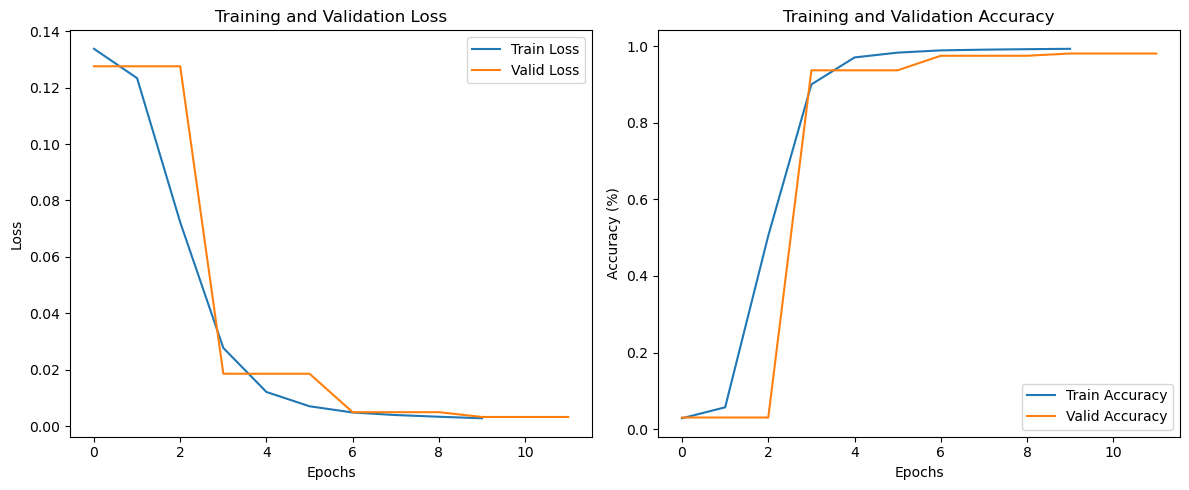

In [19]:
train()


In [26]:
test= CaptchaData(char_list,num=1, transform=data_transforms)
img,lab =test[0]

100%|██████████| 1/1 [00:00<00:00, 46.63it/s]


Predict :
['1', 'f', 't', 'j']
Ground Truth :
['1', 'f', 't', 'j']


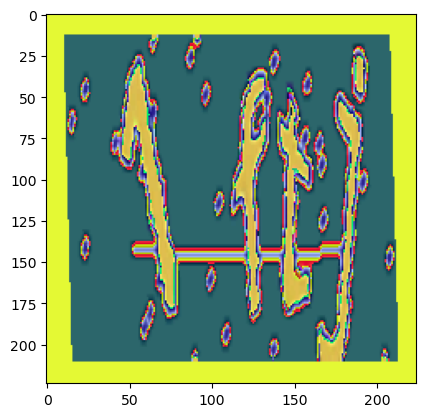

In [27]:
gt=[]
lab=lab.int().view(4,36).tolist()

column_indices = [j for row in lab for j, value in enumerate(row) if value == 1]

for c_index in column_indices:
    gt+=char_list[c_index]


model=model.to(device)
model.load_state_dict(torch.load("model.pth"))

model.eval()
prediction= model(img.unsqueeze(0).to(device)).view(4,36)
pred=torch.argmax(prediction,dim=1)

print("Predict :")
print([char_list[l.int()] for l in pred])
print("Ground Truth :")
print(gt)
plt.imshow(transforms.ToPILImage()(img))
plt.show()